In [21]:
!pip install transformers

In [40]:
import torch
import urllib.request
import nltk
import re
from bs4 import BeautifulSoup

Fetch the article text

In [34]:
url = 'https://en.wikipedia.org/wiki/India'

In [ ]:
# Scrape article using bs4 to extract all paragraphs from the online article.
raw_html = urllib.request.urlopen(url)
raw_html = raw_html.read()

article_html = BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')

# Creating a document 'article_text' containing all the sentences in the article.
article_text = ''
for para in article_paragraphs:
    article_text += para.text

print(article_text)

In [47]:
# Overriding above fetched article text (for now):
article_text = "In India, several traditional indigenous sports remain fairly popular, such as kabaddi, kho kho, pehlwani and gilli-danda. Some of the earliest forms of Asian martial arts, such as kalarippayattu, musti yuddha, silambam, and marma adi, originated in India. Chess, commonly held to have originated in India as chaturaṅga, is regaining widespread popularity with the rise in the number of Indian grandmasters.[426][427] Pachisi, from which parcheesi derives, was played on a giant marble court by Akbar.[428]The improved results garnered by the Indian Davis Cup team and other Indian tennis players in the early 2010s have made tennis increasingly popular in the country.[429] India has a comparatively strong presence in shooting sports, and has won several medals at the Olympics, the World Shooting Championships, and the Commonwealth Games.[430][431] Other sports in which Indians have succeeded internationally include badminton[432] (Saina Nehwal and P V Sindhu are two of the top-ranked female badminton players in the world), boxing,[433] and wrestling.[434] Football is popular in West Bengal, Goa, Tamil Nadu, Kerala, and the north-eastern states.[435]"
print(article_text)

In India, several traditional indigenous sports remain fairly popular, such as kabaddi, kho kho, pehlwani and gilli-danda. Some of the earliest forms of Asian martial arts, such as kalarippayattu, musti yuddha, silambam, and marma adi, originated in India. Chess, commonly held to have originated in India as chaturaṅga, is regaining widespread popularity with the rise in the number of Indian grandmasters.[426][427] Pachisi, from which parcheesi derives, was played on a giant marble court by Akbar.[428]The improved results garnered by the Indian Davis Cup team and other Indian tennis players in the early 2010s have made tennis increasingly popular in the country.[429] India has a comparatively strong presence in shooting sports, and has won several medals at the Olympics, the World Shooting Championships, and the Commonwealth Games.[430][431] Other sports in which Indians have succeeded internationally include badminton[432] (Saina Nehwal and P V Sindhu are two of the top-ranked female b

Clean the article text to remove extra whitespaces and reference numbers (such as "[23]")

In [48]:
article_text = re.sub(r'\[\d+\]', '', article_text)
article_text = re.sub(r'\[\w\]', '', article_text)
article_text = re.sub(r'\s+', ' ', article_text).strip()

print(article_text)

In India, several traditional indigenous sports remain fairly popular, such as kabaddi, kho kho, pehlwani and gilli-danda. Some of the earliest forms of Asian martial arts, such as kalarippayattu, musti yuddha, silambam, and marma adi, originated in India. Chess, commonly held to have originated in India as chaturaṅga, is regaining widespread popularity with the rise in the number of Indian grandmasters. Pachisi, from which parcheesi derives, was played on a giant marble court by Akbar.The improved results garnered by the Indian Davis Cup team and other Indian tennis players in the early 2010s have made tennis increasingly popular in the country. India has a comparatively strong presence in shooting sports, and has won several medals at the Olympics, the World Shooting Championships, and the Commonwealth Games. Other sports in which Indians have succeeded internationally include badminton (Saina Nehwal and P V Sindhu are two of the top-ranked female badminton players in the world), box

Load the model

In [49]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Load BERT's tokenizer

In [50]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Sample test for QnA

In [51]:
question = "Which sports does India play?"

Concatenate the question and context. The tokenizer places the special SEP token in between the question and the context.

In [52]:
# Apply the tokenizer to the input text, treating them as a text-pair.
input_ids = tokenizer.encode(question, article_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 248 tokens.


Show the token with its corresponding ID to see how the tokenizing operation's output

In [53]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# For each token and its id...
for token, id in zip(tokens, input_ids):
    
    # If this is the [SEP] token, add some space around it to make it stand out.
    if id == tokenizer.sep_token_id:
        print('')
    
    # Print the token string and its ID in two columns.
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
which         2,029
sports        2,998
does          2,515
india         2,634
play          2,377
?             1,029

[SEP]           102

in            1,999
india         2,634
,             1,010
several       2,195
traditional   3,151
indigenous    6,284
sports        2,998
remain        3,961
fairly        7,199
popular       2,759
,             1,010
such          2,107
as            2,004
ka           10,556
##bad         9,024
##di          4,305
,             1,010
k             1,047
##ho          6,806
k             1,047
##ho          6,806
,             1,010
pe           21,877
##hl          7,317
##wani       29,092
and           1,998
gill         12,267
##i           2,072
-             1,011
dan           4,907
##da          2,850
.             1,012
some          2,070
of            1,997
the           1,996
earliest      5,700
forms         3,596
of            1,997
asian         4,004
martial       7,761
arts          2,840
,             1,01

In addition to the SEP token, BERT requires a segment ID to differentiate between the question tokens and the answer tokens.

Segment A is for the question tokens and Segment B id is for context tokens.

BERT maps these as 0s for Segment A tokens and 1s for Segment B tokens.

Hence, first find the index of first instance of SEP token to get the number of Segment A tokens (i.e. question tokens) and construct the list of 0s and 1s.


In [54]:
# Search the input_ids for the first instance of the `[SEP]` token.
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token istelf.
num_seg_a = sep_index + 1

# The remainder are segment B.
num_seg_b = len(input_ids) - num_seg_a

# Construct the list of 0s and 1s.
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# There should be a segment_id for every input token.
assert len(segment_ids) == len(input_ids)

Feeding the data to BERT

In [55]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text


Find the highest "start" and "end" scores to get the answer span.

In [56]:
# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# Combine the tokens in the answer and print it out.
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "badminton ( sai ##na ne ##hwa ##l and p v sindh ##u are two of the top - ranked female badminton players in the world ) , boxing , and wrestling"


Displaying the answer in a better way:

In [57]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "badminton ( saina nehwal and p v sindhu are two of the top - ranked female badminton players in the world ) , boxing , and wrestling"


Visualizing the scores

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [59]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


Visualize the highest "start" word score

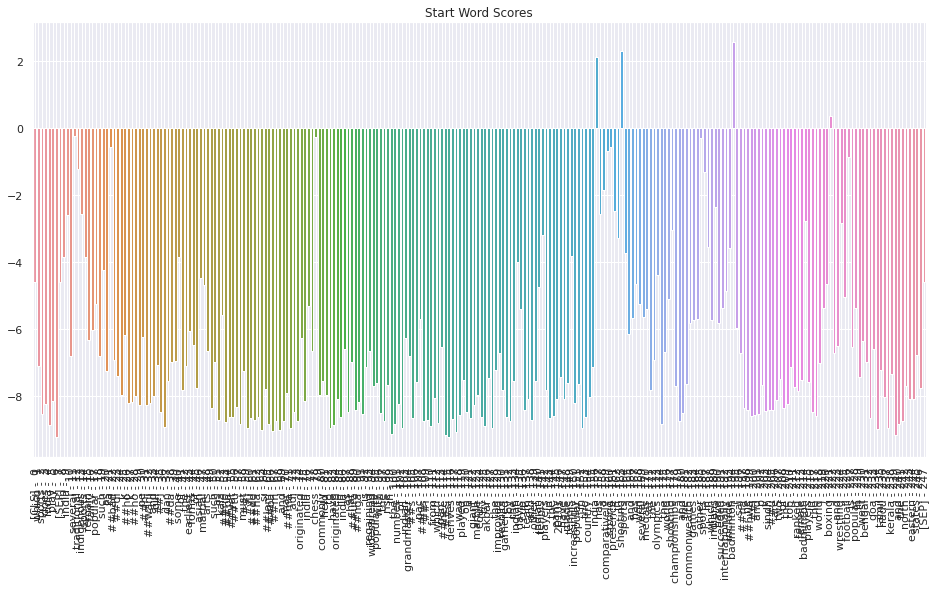

In [60]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

Visualize the highest "end" word score

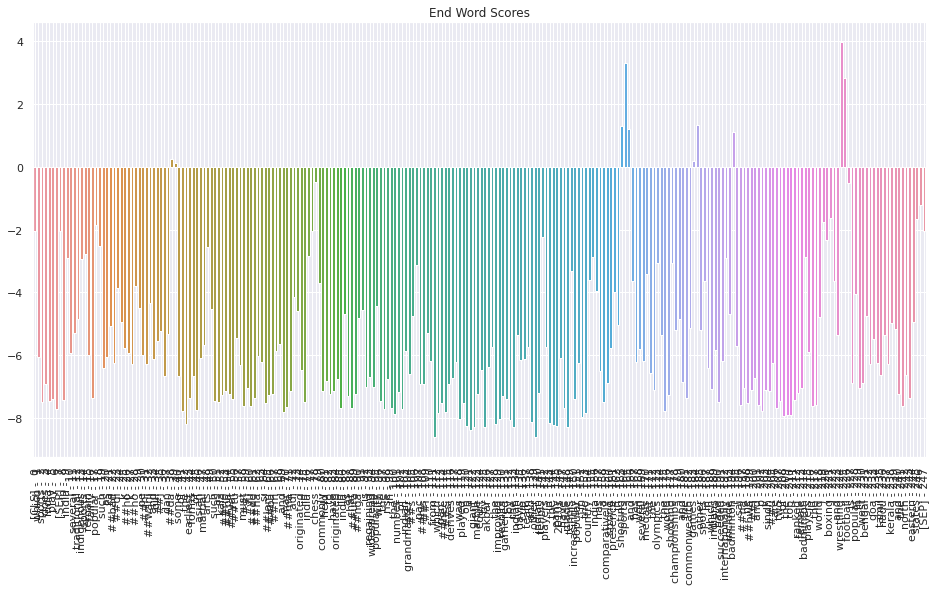

In [61]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

Modularizing the above prediction process:

In [62]:
def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)

    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example question through the model.
    start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                    token_type_ids=torch.tensor([segment_ids])) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

In [74]:
def clean_text(article_text):
  article_text = re.sub(r'\[\d+\]', '', article_text)
  article_text = re.sub(r'\[\w\]', '', article_text)
  article_text = re.sub(r'\s+', ' ', article_text).strip()
  return article_text

In [75]:
article_text = "India, officially the Republic of India (Hindi: Bhārat Gaṇarājya),[23] is a country in South Asia. It is the second-most populous country, the seventh-largest country by area, and the most populous democracy in the world. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west;[f] China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand and Indonesia. "
article_text = clean_text(article_text)
question = "Which countries are in close proximity to India?"
answer_question(question, article_text)

Query has 149 tokens.

Answer: "sri lanka and the maldives"


In [77]:
article_text = "India, officially the Republic of India (Hindi: Bhārat Gaṇarājya),[23] is a country in South Asia. It is the second-most populous country, the seventh-largest country by area, and the most populous democracy in the world. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west;[f] China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is in the vicinity of Sri Lanka and the Maldives; its Andaman and Nicobar Islands share a maritime border with Thailand and Indonesia. "
question = "Which sea is to the southwest of India?"
article_text = clean_text(article_text)
answer_question(question, article_text)

Query has 149 tokens.

Answer: "arabian sea"


In [79]:
article_text = "Cricket is a bat-and-ball game played between two teams of eleven players on a field at the centre of which is a 20-metre (22-yard) pitch with a wicket at each end, each comprising two bails balanced on three stumps. The batting side scores runs by striking the ball bowled at the wicket with the bat, while the bowling and fielding side tries to prevent this and dismiss each batter (so they are out). Means of dismissal include being bowled, when the ball hits the stumps and dislodges the bails, and by the fielding side catching the ball after it is hit by the bat, but before it hits the ground. When ten batters have been dismissed, the innings ends and the teams swap roles. The game is adjudicated by two umpires, aided by a third umpire and match referee in international matches. They communicate with two off-field scorers who record the match's statistical information."
question = "What is the size of the pitch in Cricket?"
article_text = clean_text(article_text)
answer_question(question, article_text)

Query has 208 tokens.

Answer: "20 - metre ( 22 - yard )"


In [81]:
article_text = "Tesla, Inc. (formerly Tesla Motors, Inc.) is an American electric vehicle and clean energy company based in Palo Alto, California.[9] The company specializes in electric vehicle manufacturing, battery energy storage from home to grid scale and, through its acquisition of SolarCity, solar panel and solar roof tile manufacturing.[10] Founded in July 2003 by engineers Martin Eberhard and Marc Tarpenning as Tesla Motors, the company’s name is a tribute to inventor and electrical engineer Nikola Tesla. The next three employees were Ian Wright, Elon Musk, and J. B. Straubel, all of whom are named as co-founders of the company. [2] Musk, who formerly served as chairman and is the current CEO, said that he envisioned Tesla Motors as a technology company and independent automaker, aimed at eventually offering electric cars at prices affordable to the average consumer. In February 2017, Tesla Motors shortened its name to Tesla, Inc. "
question = "What are the founders of Tesla Motors?"
article_text = clean_text(article_text)
answer_question(question, article_text)

Query has 200 tokens.

Answer: "martin eberhard and marc tarpenning"
